In [1]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)


2.12.0-rc0


AttributeError: module 'tensorflow_datasets.version' has no attribute 'VERSION'

In [2]:
# Define Constants
vocab_size = 20000  # Vocabulary size for word embedding
attention_dim = 512  # Size of dense layer in attention mechanism
word_embedding_dim = 128 # Dimensionality of word embeddings

# InceptionResNetV2 takes (299, 299, 3) image as inputs and return features in (8, 8, 1536) shape
feature_extractor = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
) # initializes the InceptionResNetV2 model with pretrained weights from ImageNet and excludes the top (output) layer
image_height = 299
image_width = 299
image_channels = 3
feature_shape = (8, 8, 1536) # shape of the feature vector that the InceptionResNetV2 model will output

219055592/219055592 [==============================] - 6s 0us/step


In [4]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (image_height, image_width))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

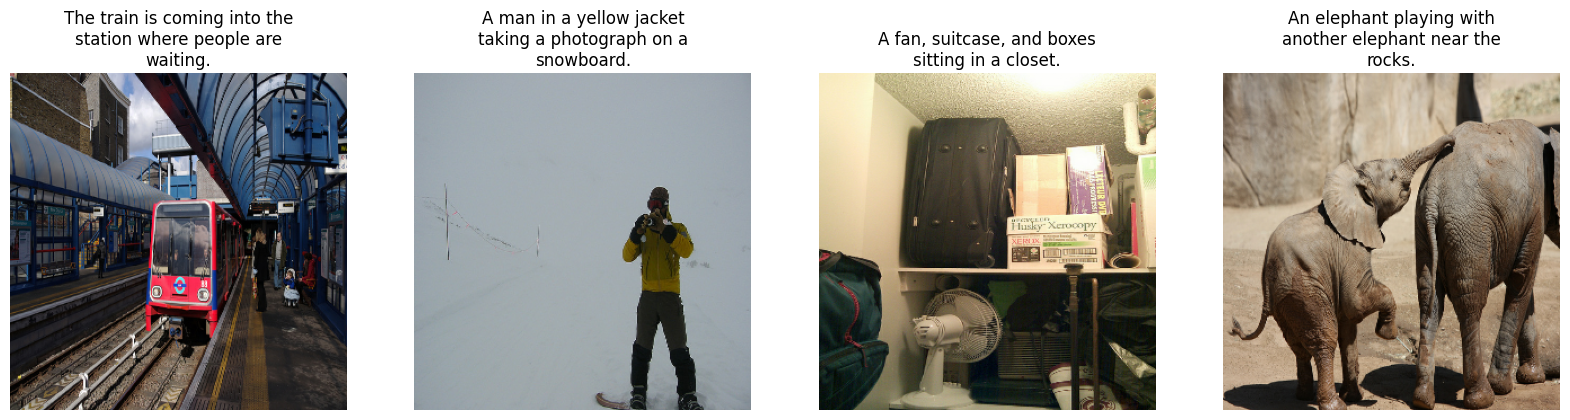

In [5]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

**Text preprocessing**

In [6]:
#function add_start_end_token is designed to add start and end tokens to the captions in the dataset
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

**Tokenizing the caption** ( text captions into integer sequences using the TextVectorization layer)



In [7]:
max_len=64 #captions longer than this length will be truncated, and shorter captions will be padded with zeros

#lowercase the text and remove punctuation
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=vocab_size,
    standardize=standardize,
    output_sequence_length=max_len,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))


In [8]:
tokenizer(['<start> my name is yuzia <end>']) #sample testing

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[   3, 3786, 1467,   11,    1,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [9]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [10]:
sample_captions

[b'<start> some people are standing near some public toilets <end>',
 b'<start> A couple of people holding snow boards in the snow. <end>',
 b'<start> A bowl with food sitting next to two glasses. <end>',
 b'<start> A black dog laying on top of a bed holding a white teddy bear. <end>',
 b'<start> A man and his son playing Frisbee in a park <end>']

In [11]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3   36   20   24   15   46   36  511  876    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2   54    5   20   26   67  559    8    7   67    4    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2  153    9   59   14   16   13   17  277    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [12]:
for wid in tokenizer([sample_captions[0]])[0]:
  print(tokenizer.get_vocabulary()[wid],end=" ")


<start> some people are standing near some public toilets <end>                                                       

In [13]:
#word to index convertor
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

#index to word convertor
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [14]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [15]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3 1531   24   90   41   21    2   91  207  327    2   58  131    4
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[1531   24   90   41   21    2   91  207  327    2   58  131    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[  3   2  42 123   9  36 515  10 517   6   7 124   4   0   0   0   0   0
   0   0   0   0   0   0   0   0  

**DESIGNING IMAGE CAPTIONING MODEL**- *image encoder + caption decoder*

In [18]:
#Image Encoder
feature_extractor.trainable = False #to prevents its weight from updating during training

image_input = Input(shape=(image_height, image_width, image_channels)) # shape of the input images
image_features = feature_extractor(image_input) #input image are passed thru the pre trained model to extract features

x = Reshape((feature_shape[0] * feature_shape[1], feature_shape[2]))(
    image_features
)#reshape features


encoder_output = Dense(attention_dim, activation="relu")(x) #  fully connected (Dense) layer is applied to the reshaped features to reduce the dimensionality of the feature vector to ATTENTION_DIM.this step helps in compressing the feature representation and preparing it for further processing by the attention mechanism.

In [19]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output) #this keras model represents the image encoder component of the overall image captioning model
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [21]:
#caption decoder

#step 1 input: current word token as a batch
word_input = Input(shape=(max_len), name="words")

#step 2 embedding layer: embed word token to attention_dim
embed_x = Embedding(vocab_size, attention_dim)(word_input)

#step 3 GRU Layer: processes the embedding word token and returns GRU output///
decoder_gru = GRU(
    attention_dim,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

#step 4 bahdanau attention mechanism:
#computes attention weights based on :: GRU output feature --> query vector ,,,,, encoder output features --> key vector
decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

#step 5 skip connection : add GRU output and attention output (i.e., context_vector, here)
addition= Add()([gru_output, context_vector])

#step 6 layer normalization: to stabalize the training process
layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

#step 7 create dense layer
decoder_output_dense = Dense(vocab_size)
decoder_output = decoder_output_dense(layer_norm_out)


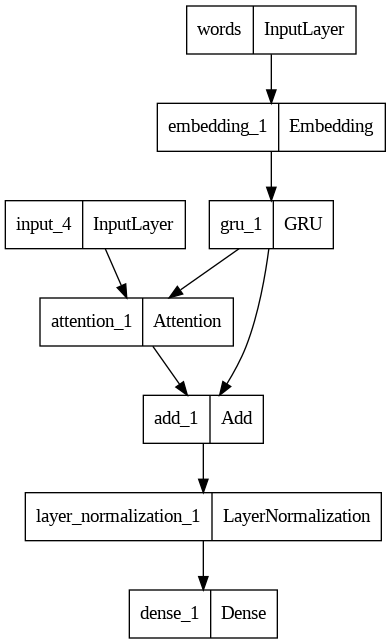

In [22]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [24]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru_1 (GRU)                 [(None, 64, 512),            1575936   ['embedding_1[1][0]']         
                              (None, 512)]                                                        
                                                                                            

**TRAINING THE MODEL**

In [25]:
#combining encoder and decoder into an image model for training
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

**LOSS FUNCTION**

In [26]:
#loss function: diff b/w predicted caption and ground truth caption
#here the loss function is sparse categorical crossentropy commonly used for sequence prediction tasks

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [27]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

In [28]:
#training loop

history = image_caption_train_model.fit(batched_ds, epochs=10)

Epoch 1/10
2586/2586 [==============================] - 967s 363ms/step - loss: 0.5736
Epoch 2/10
2586/2586 [==============================] - 950s 364ms/step - loss: 0.4217
Epoch 3/10
2586/2586 [==============================] - 949s 364ms/step - loss: 0.3704
Epoch 4/10
2586/2586 [==============================] - 946s 363ms/step - loss: 0.3315
Epoch 5/10
2586/2586 [==============================] - 950s 364ms/step - loss: 0.3017
Epoch 6/10
2586/2586 [==============================] - 951s 364ms/step - loss: 0.2776
Epoch 7/10
2586/2586 [==============================] - 955s 366ms/step - loss: 0.2577
Epoch 8/10
2586/2586 [==============================] - 978s 364ms/step - loss: 0.2415
Epoch 9/10
2586/2586 [==============================] - 947s 363ms/step - loss: 0.2277
Epoch 10/10
2586/2586 [==============================] - 950s 364ms/step - loss: 0.2165


*model for caption generation*

In [29]:
#hidden state of GRU layer
gru_state_input = Input(shape=(attention_dim), name="gru_state_input") #allows model to recieve the previous state of GRU at each time step during the caption generation

gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input) #reusing the trained GRU Layer

#reusing other layer as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

#prediction model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)

In [30]:
min_seq_len = 5  #len of generated cap
def predict_caption(filename):
    gru_state = tf.zeros((1, attention_dim))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=image_channels)
    img = tf.image.resize(img, (image_height, image_width))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(max_len):  #generate caption one word at a time
      predictions, gru_state = decoder_pred_model(
          [dec_input, gru_state, features]
          ) #predicts the next word in the input seq
      top_probs, top_idxs = tf.math.top_k(
          input=predictions[0][0], k=10, sorted=False
          )
      # selects the top-K words with the highest probabilities from the logits.
      # here  top_prob ---> probability ,, top_index---> corresponding word indeces
      chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
      predicted_id = top_idxs.numpy()[chosen_id][0]
      result.append(tokenizer.get_vocabulary()[predicted_id])

      if predicted_id == word_to_index("<end>"):
        return img, result

      dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

a dog that is on a grass field.
a dog and a frisbee indoors on a picnic table.


(-0.5, 225.5, 222.5, -0.5)

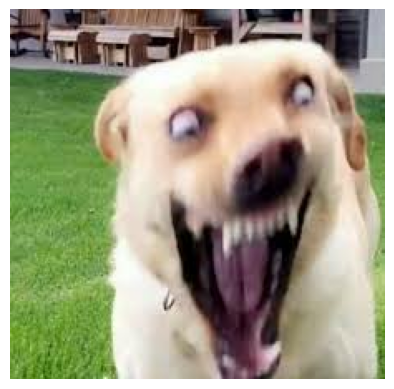

In [33]:
#testing
filename= "/content/exampleimage.jpeg"
for i in range(2):
  image, caption= predict_caption(filename)
  print(" ".join(caption[:-1])+".")

img= tf.image.decode_jpeg(tf.io.read_file(filename), channels=image_channels)
plt.imshow(img)
plt.axis("off")